In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:22pt;}
div.text_cell_render.rendered_html{font-size:18pt;}
div.text_cell_render.rendered_html{font-size:15pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:18pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:18pt;padding:5px;}
table.dataframe{font-size:18px;}
</style>
"""))

<span style='color:green; font-size:32px;'>ch_5.**LSTM/GRU**</span>
- 5만개 영화 감상평(독립변수) → 부정/긍정(타겟변수)

# 1. 패키지

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,GRU
from time import time # 70.1.1부터 현재까지의 밀리세컨

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score

# 2. 하이퍼 파라미터 설정(이 파라미터를 바꾸면 정확도나 학습 속도에 차이남)

In [3]:
MY_WORDS = 10000 # imdb 데이터의 단어수
MY_LENGTH = 80   # imdb 영화평 단어수 80개만 독립변수
MY_EMBED = 32    # Embedding layer의 결과 차원
MY_HIDDEN = 64   # LSTM의 units 차원

# 학습시 사용할 것 (fit)
MY_EPOCH = 10    # 학습 수
MY_BATCH = 200   # batch_size (fit시 매번 데이터를 가져오는 데이터)/ 메모리가 좋으면 높이면 좋음

# 3. 데이터 불러오기

In [4]:
(x_train, y_train),(x_test,y_test) = imdb.load_data(num_words=MY_WORDS)
# x_train,x_test,y_train,y_test

In [5]:
print('학습셋 입력변수 모양 :',x_train.shape)
print('학습셋 타겟변수 모양 :',y_train.shape)
print('학습셋 샘플 :',x_train[0],y_train[2])
print('테스트셋 변수들 모양 :', x_test.shape,y_test.shape)
type(x_train),type(x_test),type(y_train),type(y_test)

학습셋 입력변수 모양 : (25000,)
학습셋 타겟변수 모양 : (25000,)
학습셋 샘플 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 0
테스트

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [6]:
# 긍정/부정 갯수 
print('학습셋의 긍정 갯수 :',y_train.sum())        # 긍정 1의 갯수
print('테스트셋의 긍정 갯수 :', y_test.sum())      

학습셋의 긍정 갯수 : 12500
테스트셋의 긍정 갯수 : 12500


# 4.문자단어 → 정수

In [7]:
word_to_id = imdb.get_word_index() # {'word':id}
print(word_to_id['what'])
print(word_to_id['movie'])
print(word_to_id['film'])
print(word_to_id['sonja'])
print(word_to_id['a'])
print(word_to_id['the'])
# 정수 → 문자 단어 
id_to_word = {}  #{1:'the',3:'a',16816:'sonja'}
for word, value in word_to_id.items():
    id_to_word[value] = word
print(id_to_word[1])
print(id_to_word[3])

48
17
19
16816
3
1
the
a


In [8]:
word_to_id

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [9]:
msg = "What a wonderful movie"
msg = msg.lower().split() # 대문자 → 소문자 / 단어별 분리
# 1,2,3은 알파벳 단어가 아님
# 1:리뷰시작을 알리는 숫자 , 2:문자가 짤려서 잘못읽어옴, 3:padding 처리 
data = [1] + [word_to_id.get(m,-1)+3 for m in msg]
# word_to_id['movie']+3
print('원래 후기 내용 :', msg)
print('encodede된 data :', data)
print('추정된 data :',' '.join([ id_to_word.get(d-3,'?') for d in data]))

원래 후기 내용 : ['what', 'a', 'wonderful', 'movie']
encodede된 data : [1, 51, 6, 389, 20]
추정된 data : ? what a wonderful movie


# 5. 숫자영화평 → 자연어 영화평 return 함수

In [10]:
def decoding(review_num):
    decoded = [id_to_word.get(num-3,'???') for num in review_num]
    return ' '.join(decoded)

In [11]:
print(decoding(x_train[1]),y_train[1])

??? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ??? the hair is big lots of boobs ??? men wear those cut ??? shirts that show off their ??? sickening that men actually wore them and the music is just ??? trash that plays over and over again in almost every scene there is trashy music boobs and ??? taking away bodies and the gym still doesn't close for ??? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then 0


# 6. 영화평(입력변수)의 길이

In [12]:
def show_length(x_train):
    print('첫 20개 영화평 길이')
    print([len(x_data) for x_data in x_train[:20]])

In [13]:
[ len(x_data) for x_data in x_train]

[218,
 189,
 141,
 550,
 147,
 43,
 123,
 562,
 233,
 130,
 450,
 99,
 117,
 238,
 109,
 129,
 163,
 752,
 212,
 177,
 129,
 140,
 256,
 888,
 93,
 142,
 220,
 193,
 171,
 221,
 174,
 647,
 233,
 162,
 597,
 234,
 51,
 336,
 139,
 231,
 704,
 142,
 861,
 132,
 122,
 570,
 55,
 214,
 103,
 186,
 113,
 169,
 469,
 138,
 302,
 766,
 351,
 146,
 59,
 206,
 107,
 152,
 186,
 431,
 147,
 684,
 383,
 324,
 252,
 263,
 787,
 211,
 314,
 118,
 390,
 132,
 710,
 306,
 167,
 115,
 95,
 158,
 156,
 82,
 502,
 314,
 190,
 174,
 60,
 145,
 214,
 659,
 408,
 515,
 461,
 202,
 238,
 170,
 107,
 171,
 158,
 145,
 790,
 258,
 287,
 67,
 123,
 975,
 775,
 236,
 195,
 274,
 214,
 91,
 1038,
 815,
 183,
 206,
 50,
 118,
 147,
 141,
 60,
 56,
 439,
 439,
 213,
 144,
 533,
 303,
 203,
 563,
 129,
 153,
 55,
 92,
 174,
 187,
 183,
 165,
 78,
 198,
 156,
 223,
 127,
 61,
 362,
 84,
 57,
 176,
 159,
 57,
 159,
 165,
 213,
 194,
 149,
 130,
 203,
 19,
 98,
 466,
 525,
 130,
 322,
 153,
 408,
 215,
 472,
 143,
 1

In [14]:
print('제일 긴 영화평 단어 길이 :',
     max(len(x_data)for x_data in x_train))
print('제일 짧은 영화평 단어 길이 :',
     min(len(x_data)for x_data in x_train))
print('영화평 단어 길이 중위수 :',
     np.median([len(x_data) for x_data in x_train]))


제일 긴 영화평 단어 길이 : 2494
제일 짧은 영화평 단어 길이 : 11
영화평 단어 길이 중위수 : 178.0


# 7. 모든 영화평 길이를 동일하게(MY_LENGTH=80)

In [15]:
X_train = pad_sequences(x_train,
                        padding='pre',     # pre :앞 맞춤 
                        truncating='pre',  # 뒷부분을 자르고 앞부분을 남김
                        maxlen=MY_LENGTH,
                        ) 
X_test = pad_sequences(x_test,
                        padding='pre',     
                        truncating='pre', 
                        maxlen=MY_LENGTH,
                        ) 
show_length(X_train),show_length(X_test)

첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


(None, None)

# 8. 최종 데이터 shape확인


In [16]:
X_train.shape , y_train.shape,X_test.shape,y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

In [17]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [18]:
X_train[0] 
# 1차원 리스트를 2차원 넘파이로 됨

array([  15,  256,    4,    2,    7, 3766,    5,  723,   36,   71,   43,
        530,  476,   26,  400,  317,   46,    7,    4,    2, 1029,   13,
        104,   88,    4,  381,   15,  297,   98,   32, 2071,   56,   26,
        141,    6,  194, 7486,   18,    4,  226,   22,   21,  134,  476,
         26,  480,    5,  144,   30, 5535,   18,   51,   36,   28,  224,
         92,   25,  104,    4,  226,   65,   16,   38, 1334,   88,   12,
         16,  283,    5,   16, 4472,  113,  103,   32,   15,   16, 5345,
         19,  178,   32])

# 9. 모델 생성

In [19]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,      # 10000
                     output_dim=MY_EMBED,     # 32 
                     input_length=MY_LENGTH,  # 80
                     ))
# RNN : 입력 단어의 길이 수가 너무 길면 파라미터 업데이트 안 됨
# 개선모델1. LSTM / 개선모델2. GRU
model.add(GRU(units=MY_HIDDEN,
               input_shape=(MY_LENGTH, MY_EMBED)))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            320000    
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 338,881
Trainable params: 338,881
Non-trainable params: 0
_________________________________________________________________


# 10.학습과정 설정 및 학습하기

In [20]:
%%time
model.compile(loss='binary_crossentropy', # 이진분류
              optimizer='adam',
              metrics=['acc'])
begin = time() # 70.1.1부터 현재까지의 초수

hist = model.fit(X_train, y_train,
                 epochs=MY_EPOCH,
                 batch_size=MY_BATCH,
                 validation_split=0.2,
                 verbose=1)
end = time() # 70.1.1부터 이 시점까지의 초수
print('총 학습시간 :',(end-begin))

Epoch 1/10
100/100 [==============================] - 11s 96ms/step - loss: 0.5467 - acc: 0.7007 - val_loss: 0.3847 - val_acc: 0.8256
Epoch 2/10
100/100 [==============================] - 9s 89ms/step - loss: 0.3062 - acc: 0.8715 - val_loss: 0.3595 - val_acc: 0.8368
Epoch 3/10
100/100 [==============================] - 9s 86ms/step - loss: 0.2373 - acc: 0.9068 - val_loss: 0.3994 - val_acc: 0.8306
Epoch 4/10
100/100 [==============================] - 8s 85ms/step - loss: 0.1907 - acc: 0.9301 - val_loss: 0.4356 - val_acc: 0.8214
Epoch 5/10
100/100 [==============================] - 8s 85ms/step - loss: 0.1620 - acc: 0.9431 - val_loss: 0.4557 - val_acc: 0.8158
Epoch 6/10
100/100 [==============================] - 8s 85ms/step - loss: 0.1424 - acc: 0.9501 - val_loss: 0.5490 - val_acc: 0.8126
Epoch 7/10
100/100 [==============================] - 9s 85ms/step - loss: 0.1217 - acc: 0.9588 - val_loss: 0.6994 - val_acc: 0.8096
Epoch 8/10
100/100 [==============================] - 8s 83ms/step -

In [21]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

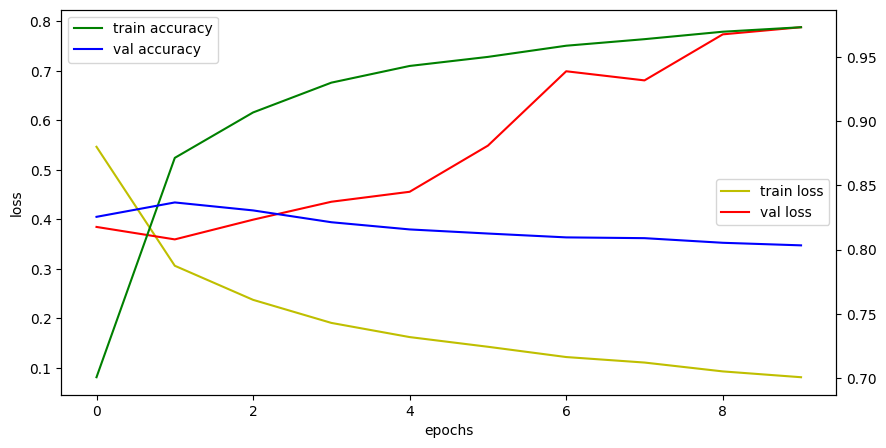

In [22]:
# 모델 학습과정 시각화 
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'],'r', label='val loss')
acc_ax= loss_ax.twinx() #x축 공유
acc_ax.plot(hist.history['acc'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('acc')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

#  11. 모델 평가 

In [23]:
# pad_sequences 'post' 49.49%
loss,acc = model.evaluate(X_test,y_test)
print('정확도 :',acc)

782/782 [==============================] - 7s 8ms/step - loss: 0.7785 - acc: 0.8018
정확도 : 0.8017600178718567


In [24]:
# 혼동행렬, recall, precision을 위한 yhat 
yhat = (model.predict(X_test) > 0.5).astype(np.int16).reshape(-1)
yhat

782/782 [==============================] - 7s 8ms/step


array([0, 1, 1, ..., 0, 0, 1], dtype=int16)

In [25]:
# 진짜값
y_test

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [26]:
# 혼돈행렬 
confusion_matrix(y_test,yhat)
# 부정부정 /부정긍정
# 긍정부정 / 긍정긍정

array([[10039,  2461],
       [ 2495, 10005]], dtype=int64)

In [27]:
# recall (실제 True인것들 중 True로 예측한 비율) 9842 /(2658+9842=12500)
recall_score(y_test,yhat)

0.8004

In [28]:
# precision(True로 예측한 것 중 실제값이 True인 비율)  9842/(2357+9842=12199)
precision_score(y_test,yhat)

0.8025830258302583

# 12. 모델 사용하기 

In [29]:
# # 긍정 리뷰
# review = '''The movie is fun
# As expected, I realized again that the movie was no joke when I watched it in the theater. 
# The story, the direction, and the sound were all so good.@@'''.lower()
# import re
# review = re.sub('[^a-zA-Z\'\s]', '',review)
# print('영화평(특수문자 제외) :',review)
# review = review.split() # 단어 list
# review = [1] + [word_to_id.get(word,-1)+3 for word in review]
# print(review, len(review))

In [30]:
# 부정 리뷰 
review = '''The movie is so boring.
It's below expectations. 
Maybe because I only think about directing, 
I can't connect the story at all, 
and I don't know the actors' acting skills.@@'''.lower()
import re
review = re.sub('[^a-zA-Z\'\s]', '',review)
print('영화평(특수문자 제외) :',review)
review = review.split() # 단어 list
review = [1] + [word_to_id.get(word,-1)+3 for word in review]
print(review, len(review))

영화평(특수문자 제외) : the movie is so boring
it's below expectations 
maybe because i only think about directing 
i can't connect the story at all 
and i don't know the actors' acting skills
[1, 4, 20, 9, 38, 357, 45, 1908, 1398, 279, 88, 13, 64, 104, 44, 940, 13, 191, 3807, 4, 65, 33, 32, 5, 13, 92, 124, 4, 6841, 116, 1959] 31


In [31]:
input_data = pad_sequences([review],
                        padding='pre',     
                        truncating='pre', 
                        maxlen=MY_LENGTH,
                        ) 
input_data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,    4,   20,    9,   38,  357,
          45, 1908, 1398,  279,   88,   13,   64,  104,   44,  940,   13,
         191, 3807,    4,   65,   33,   32,    5,   13,   92,  124,    4,
        6841,  116, 1959]])

In [32]:
result = (model.predict(input_data)> 0.5).astype(np.int8).reshape(-1)
result 

1/1 [==============================] - 0s 19ms/step


array([0], dtype=int8)